# ML Pipeline Scoring new Data

We we'll be doing here is to repeat every process from feature engineering to prediction on the test data for this project

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import scipy.stats as stats

import joblib


In [6]:
data = pd.read_csv('test.csv')

print(data.shape)

data.head(4)

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal


In [7]:
# drop id column

data.drop('Id', axis = 1, inplace=True)

data.shape

(1459, 79)

## Feature Engineering

1. Missing values
3. Temporal variables
3. Non-Gaussian distributed variables
4. Categorical variables: remove rare labels
5. Categorical variables: convert string to numbers
6. Put the variables in a similar scale

### Missing values

In [8]:
# during featurinf MSSubClass was cast as a categorical variable
# the same thing will be done 

data['MSSubClass'] = data['MSSubClass'].astype('O')

In [9]:
# we fill variuous category of categorical variables

with_string_missing = ['Alley', 'FireplaceQu',
                       'PoolQC', 'Fence', 'MiscFeature']

with_mode_missing = {
    'MasVnrType': 'None',
    'BsmtQual': 'TA',
    'BsmtCond': 'TA',
    'BsmtExposure': 'No',
    'BsmtFinType1': 'Unf',
    'BsmtFinType2': 'Unf',
    'Electrical': 'SBrkr',
    'GarageType': 'Attchd',
    'GarageFinish': 'Unf',
    'GarageQual': 'TA',
    'GarageCond': 'TA',
}

In [10]:
with_mode_missing['GarageCond']

'TA'

In [11]:
# replace missing values with new label: Missing

data[with_string_missing] = data[with_string_missing].fillna('Missing')



In [12]:
with_mode_missing.keys()

dict_keys(['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'])

In [13]:
# replace missing values with frequent category

for var in with_mode_missing.keys():
    data[var].fillna(with_mode_missing[var], inplace = True)
    #data[var].fillna(with_mode_missing)

### Numerical variables

To engineer missing values in numerical variables, we will

1. add a binary missing value indicator column
2. replace the missing values in the original variable with the mean 

In [14]:
# from the feature engineering notebook we already obtained the mean 
# of the numerical variables with null values


vars_with_na = {
    'LotFrontage' : 69.87974098057354,
    'MasVnrArea' : 103.7974006116208,
    'GarageYrBlt' : 1978.2959677419356
}

In [15]:
# add binary indicator to the numerical variabl;e with missing va;ues

for var in vars_with_na:

    data[var + '_na'] = np.where(data[var].isnull(), 1, 0)

    data[var].fillna(vars_with_na[var], inplace = True)


data[vars_with_na].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [16]:
# let check the binary indicator column

data[['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']].tail()

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
1454,0,0,1
1455,0,0,0
1456,0,0,0
1457,0,0,1
1458,0,0,0


### Temporal Variable

As in the feature engineering notebook we will calculate the elapse time between when a house a house was sold and each of the temporal variables

In [17]:
def elapsed_time(df, var):

    df[var] = df['YrSold'] - df[var]

    return df

In [18]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    data = elapsed_time(data, var)

In [19]:
data.drop('YrSold', axis = 1, inplace=True)

In [20]:
data.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,20,RH,80.0,11622,Pave,Missing,Reg,Lvl,AllPub,Inside,...,Missing,MnPrv,Missing,0,6,WD,Normal,0,0,0
1,20,RL,81.0,14267,Pave,Missing,IR1,Lvl,AllPub,Corner,...,Missing,Missing,Gar2,12500,6,WD,Normal,0,0,0


## Numerical variable transformation

### Logarithmic transformation

We transform the positive numerical variable in order to a Gaussian-like distribution

In [21]:
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    data[var] = np.log(data[var])

### Yeo-Johnson transformation

We will apply the Yeo-Johnson transformation to LotArea
We use the lmbda value from feature engineering notebook 


In [22]:
data['LotArea'] = stats.yeojohnson(data['LotArea'], lmbda=-12.55283001172003)

### Binarized skewed Variable

In [23]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

for var in skewed:

    data[var] = np.where(data[var] == 0, 0, 1)

## Categorical variables

### Apply mappings


We remap variables with specific meaning into a numerical scale

In [24]:
qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]


for var in qual_vars:
    data[var] = data[var].map(qual_mappings)           

In [25]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'

data[var] = data[var].map(exposure_mappings)

In [26]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']


for var in finish_vars:

    data[var] = data[var].map(finish_mappings)

In [27]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

data[var] = data[var].map(garage_mappings)

In [28]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

data[var] = data[var].map(fence_mappings)

In [29]:
# check .for null in the data set

with_null = [
    var for var in data.columns if data[var].isnull().sum() > 0
]

with_null

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea',
 'SaleType']

In [30]:
# let check that these columns were also in the train set

[ 
    var for var in with_null if var in list(
        with_mode_missing.keys()
 
    ) + with_string_missing + list(vars_with_na.keys())
]

[]

#### important 

This tells there was a good number of variables with missing value in the test data that were not in the original data

### Removing Rare Labels

For the remaining categorical variables we will label with less that are present in <1% in the train data

In [31]:
# we are going to create a rare label dictionary from feature engineering notebook

frequent_ls = {
    'MSZoning': ['FV', 'RH', 'RL', 'RM'],
    'Street': ['Pave'],
    'Alley': ['Grvl', 'Missing', 'Pave'],
    'LotShape': ['IR1', 'IR2', 'Reg'],
    'LandContour': ['Bnk', 'HLS', 'Low', 'Lvl'],
    'Utilities': ['AllPub'],
    'LotConfig': ['Corner', 'CulDSac', 'FR2', 'Inside'],
    'LandSlope': ['Gtl', 'Mod'],
    'Neighborhood': ['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
                     'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
                     'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
                     'Somerst', 'StoneBr', 'Timber'],

    'Condition1': ['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'],
    'Condition2': ['Norm'],
    'BldgType': ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'],
    'HouseStyle': ['1.5Fin', '1Story', '2Story', 'SFoyer', 'SLvl'],
    'RoofStyle': ['Gable', 'Hip'],
    'RoofMatl': ['CompShg'],
    'Exterior1st': ['AsbShng', 'BrkFace', 'CemntBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],

    'Exterior2nd': ['AsbShng', 'BrkFace', 'CmentBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'Wd Shng'],

    'MasVnrType': ['BrkFace', 'None', 'Stone'],
    'Foundation': ['BrkTil', 'CBlock', 'PConc', 'Slab'],
    'Heating': ['GasA', 'GasW'],
    'CentralAir': ['N', 'Y'],
    'Electrical': ['FuseA', 'FuseF', 'SBrkr'],
    'Functional': ['Min1', 'Min2', 'Mod', 'Typ'],
    'GarageType': ['Attchd', 'Basment', 'BuiltIn', 'Detchd'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['Missing'],
    'MiscFeature': ['Missing', 'Shed'],
    'SaleType': ['COD', 'New', 'WD'],
    'SaleCondition': ['Abnorml', 'Family', 'Normal', 'Partial'],
    'MSSubClass': ['20', '30', '50', '60', '70', '75', '80', '85', '90', '120', '160', '190'],
}

In [32]:
for var in frequent_ls.keys():

    data[var] = np.where(data[var].isin(
        frequent_ls
    ), data[var], 'Rare')

### Encoding of Categorrical variables

In this section we transform the string in categorical variables into numbers

In [33]:



ordinal_mappings = {
    'MSZoning': {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4},
    'Street': {'Rare': 0, 'Pave': 1},
    'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
    'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
    'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
    'Utilities': {'Rare': 0, 'AllPub': 1},
    'LotConfig': {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4},
    'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
    'Neighborhood': {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3,
                     'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7,
                     'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11,
                     'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15,
                     'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19,
                     'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22},
    
    'Condition1': {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5},
    'Condition2': {'Rare': 0, 'Norm': 1},
    'BldgType': {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fam': 3, 'TwnhsE': 4},
    'HouseStyle': {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story': 5},
    'RoofStyle': {'Gable': 0, 'Rare': 1, 'Hip': 2},
    'RoofMatl': {'CompShg': 0, 'Rare': 1},
    'Exterior1st': {'AsbShng': 0, 'Wd Sdng': 1, 'WdShing': 2, 'MetalSd': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CemntBd': 9, 'VinylSd': 10},
    
    'Exterior2nd': {'AsbShng': 0, 'Wd Sdng': 1, 'MetalSd': 2, 'Wd Shng': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CmentBd': 9, 'VinylSd': 10},
    
    'MasVnrType': {'Rare': 0, 'None': 1, 'BrkFace': 2, 'Stone': 3},
    'Foundation': {'Slab': 0, 'BrkTil': 1, 'CBlock': 2, 'Rare': 3, 'PConc': 4},
    'Heating': {'Rare': 0, 'GasW': 1, 'GasA': 2},
    'CentralAir': {'N': 0, 'Y': 1},
    'Electrical': {'Rare': 0, 'FuseF': 1, 'FuseA': 2, 'SBrkr': 3},
    'Functional': {'Rare': 0, 'Min2': 1, 'Mod': 2, 'Min1': 3, 'Typ': 4},
    'GarageType': {'Rare': 0, 'Detchd': 1, 'Basment': 2, 'Attchd': 3, 'BuiltIn': 4},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'PoolQC': {'Missing': 0, 'Rare': 1},
    'MiscFeature': {'Rare': 0, 'Shed': 1, 'Missing': 2},
    'SaleType': {'COD': 0, 'Rare': 1, 'WD': 2, 'New': 3},
    'SaleCondition': {'Rare': 0, 'Abnorml': 1, 'Family': 2, 'Normal': 3, 'Partial': 4},
    'MSSubClass': {'30': 0, 'Rare': 1, '190': 2, '90': 3, '160': 4, '50': 5, '85': 6,
                   '70': 7, '80': 8, '20': 9, '75': 10, '120': 11, '60': 12},
}

In [34]:
for var in ordinal_mappings.keys():

    # get dict values in ordinal_mapping variable
    ordinal_label = ordinal_mappings[var]
    
    # use dictionary to replace the categorical string
    data[var] = data[var].map(ordinal_label)


In [35]:
check_null = [
    var for var in data.columns if data[var].isnull().sum() > 0
]

len(check_null)

13

In [36]:
# we do a qucik fix
# replace all null values with zeros

data.fillna(0, inplace=True)

### Feature Scaling

We will scale features to with minmax scaler from sklearn. Already, we saved this value already in our feature engineering notebook


In [37]:
scaler = joblib.load('minmax_scaler.joblib')


data = pd.DataFrame(
    scaler.transform(data),
    columns=data.columns
)

/home/arnold/Desktop/MlOp/env/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [38]:
# load pre-selected features
# from feature selection notebook
# ==========================


features = pd.read_csv('selected_features.csv')
features = features['0'].to_list()


data = data[features]

data.shape

(1459, 36)

/home/arnold/Desktop/MlOp/env/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Lasso from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


<AxesSubplot:>

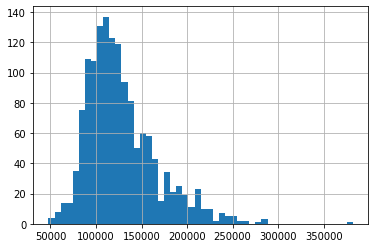

In [39]:
# load trained model

lin_model = joblib.load('linear_regression.joblib')

pred = lin_model.predict(data)

pd.Series(np.exp(pred)).hist(bins=50)